# Model for the Concentration Dynamics in Mixed-Species Liquid Cell Cultures
## Setup
### Import required Libraries
#### Maths and Plotting

In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

#### Implementation of the Model
![Reaction Scheme](reaction_scheme.png "Reaction Scheme")

In [2]:
import concentration_dynamics

### Set up ODE sysyem

In [ ]:
FILES = {
    "CONSTANTS" : "constants.yml",
    "PARAMS" : "parameters.yml",
    "INITIAL_CONDITIONS" : "initial_conditions.yml",
}

In [4]:
ode_system = concentration_dynamics.suspended_cultures_ode()
assert ode_system.load_reaction_params(FILES["CONSTANTS"]) , "Failed to load reaction parameters from constants.yml"
assert ode_system.load_gas_exchange_params(FILES["CONSTANTS"], FILES["PARAMS"]), "Failed to load gas exchange parameters"


## ODE System Solution

### Load Initial State

In [5]:
initial_state = concentration_dynamics.make_initial_state(FILES["INITIAL_CONDITIONS"])
assert initial_state is not None , "Failed to load initial state from file."
initial_state = concentration_dynamics.update_state_with_gas_at_equilibrium(initial_state, ode_system)


In [6]:
#initial_state[0] = 0.0

In [7]:
print("Initial State:")
for k,v in zip( concentration_dynamics.DEFAULT_ORDER , initial_state ):
    print(f"  c_{k}0 = {v} mol/m^3")

Initial State:
  c_A0 = 0.03 mol/m^3
  c_H0 = 0.01 mol/m^3
  c_C0 = 0.013103388349514565 mol/m^3
  c_O0 = 0.2644174248786407 mol/m^3
  c_M0 = 0.042252525 mol/m^3
  c_L0 = 70.0 mol/m^3
  c_N0 = 100.0 mol/m^3
  c_P0 = 10.0 mol/m^3


In [8]:
print("Initial Derivatives:")
for k,v in zip( concentration_dynamics.DEFAULT_ORDER , ode_system(None, initial_state) ):
    print(f"  c˙_{k} = {v} mol/m^3")

Initial Derivatives:
  c˙_A = 2.3915139684667444e-07 mol/m^3
  c˙_H = 3.7766779486094014e-09 mol/m^3
  c˙_C = -1.723318995864196e-07 mol/m^3
  c˙_O = 3.9535955406590995e-07 mol/m^3
  c˙_M = -7.262842208864233e-09 mol/m^3
  c˙_L = 0.0 mol/m^3
  c˙_N = -2.6317127126797485e-08 mol/m^3
  c˙_P = -2.4292807479528384e-09 mol/m^3


### Solve IVP

In [9]:
# time span for the simulation
#t_span = (0, 2*356*24*3600)  # 2 years in seconds
t_span = (0, 18*7*24*3600)  # 4 weeks in seconds
#t_span = (0, 24*3600)  # 1 day in seconds
#t_span = (0, 3600)  # 1 hour in seconds
#t_span = (0, 2)  # 2 seconds

# solve the ODE system
sol = solve_ivp(
    ode_system, 
    t_span, 
    initial_state, 
    method='RK45', 
    t_eval=np.linspace(t_span[0], t_span[1], num=10000), 
    events=concentration_dynamics.IVP_SOLUTION_TERMINATION_EVENTS 
)

### Plots

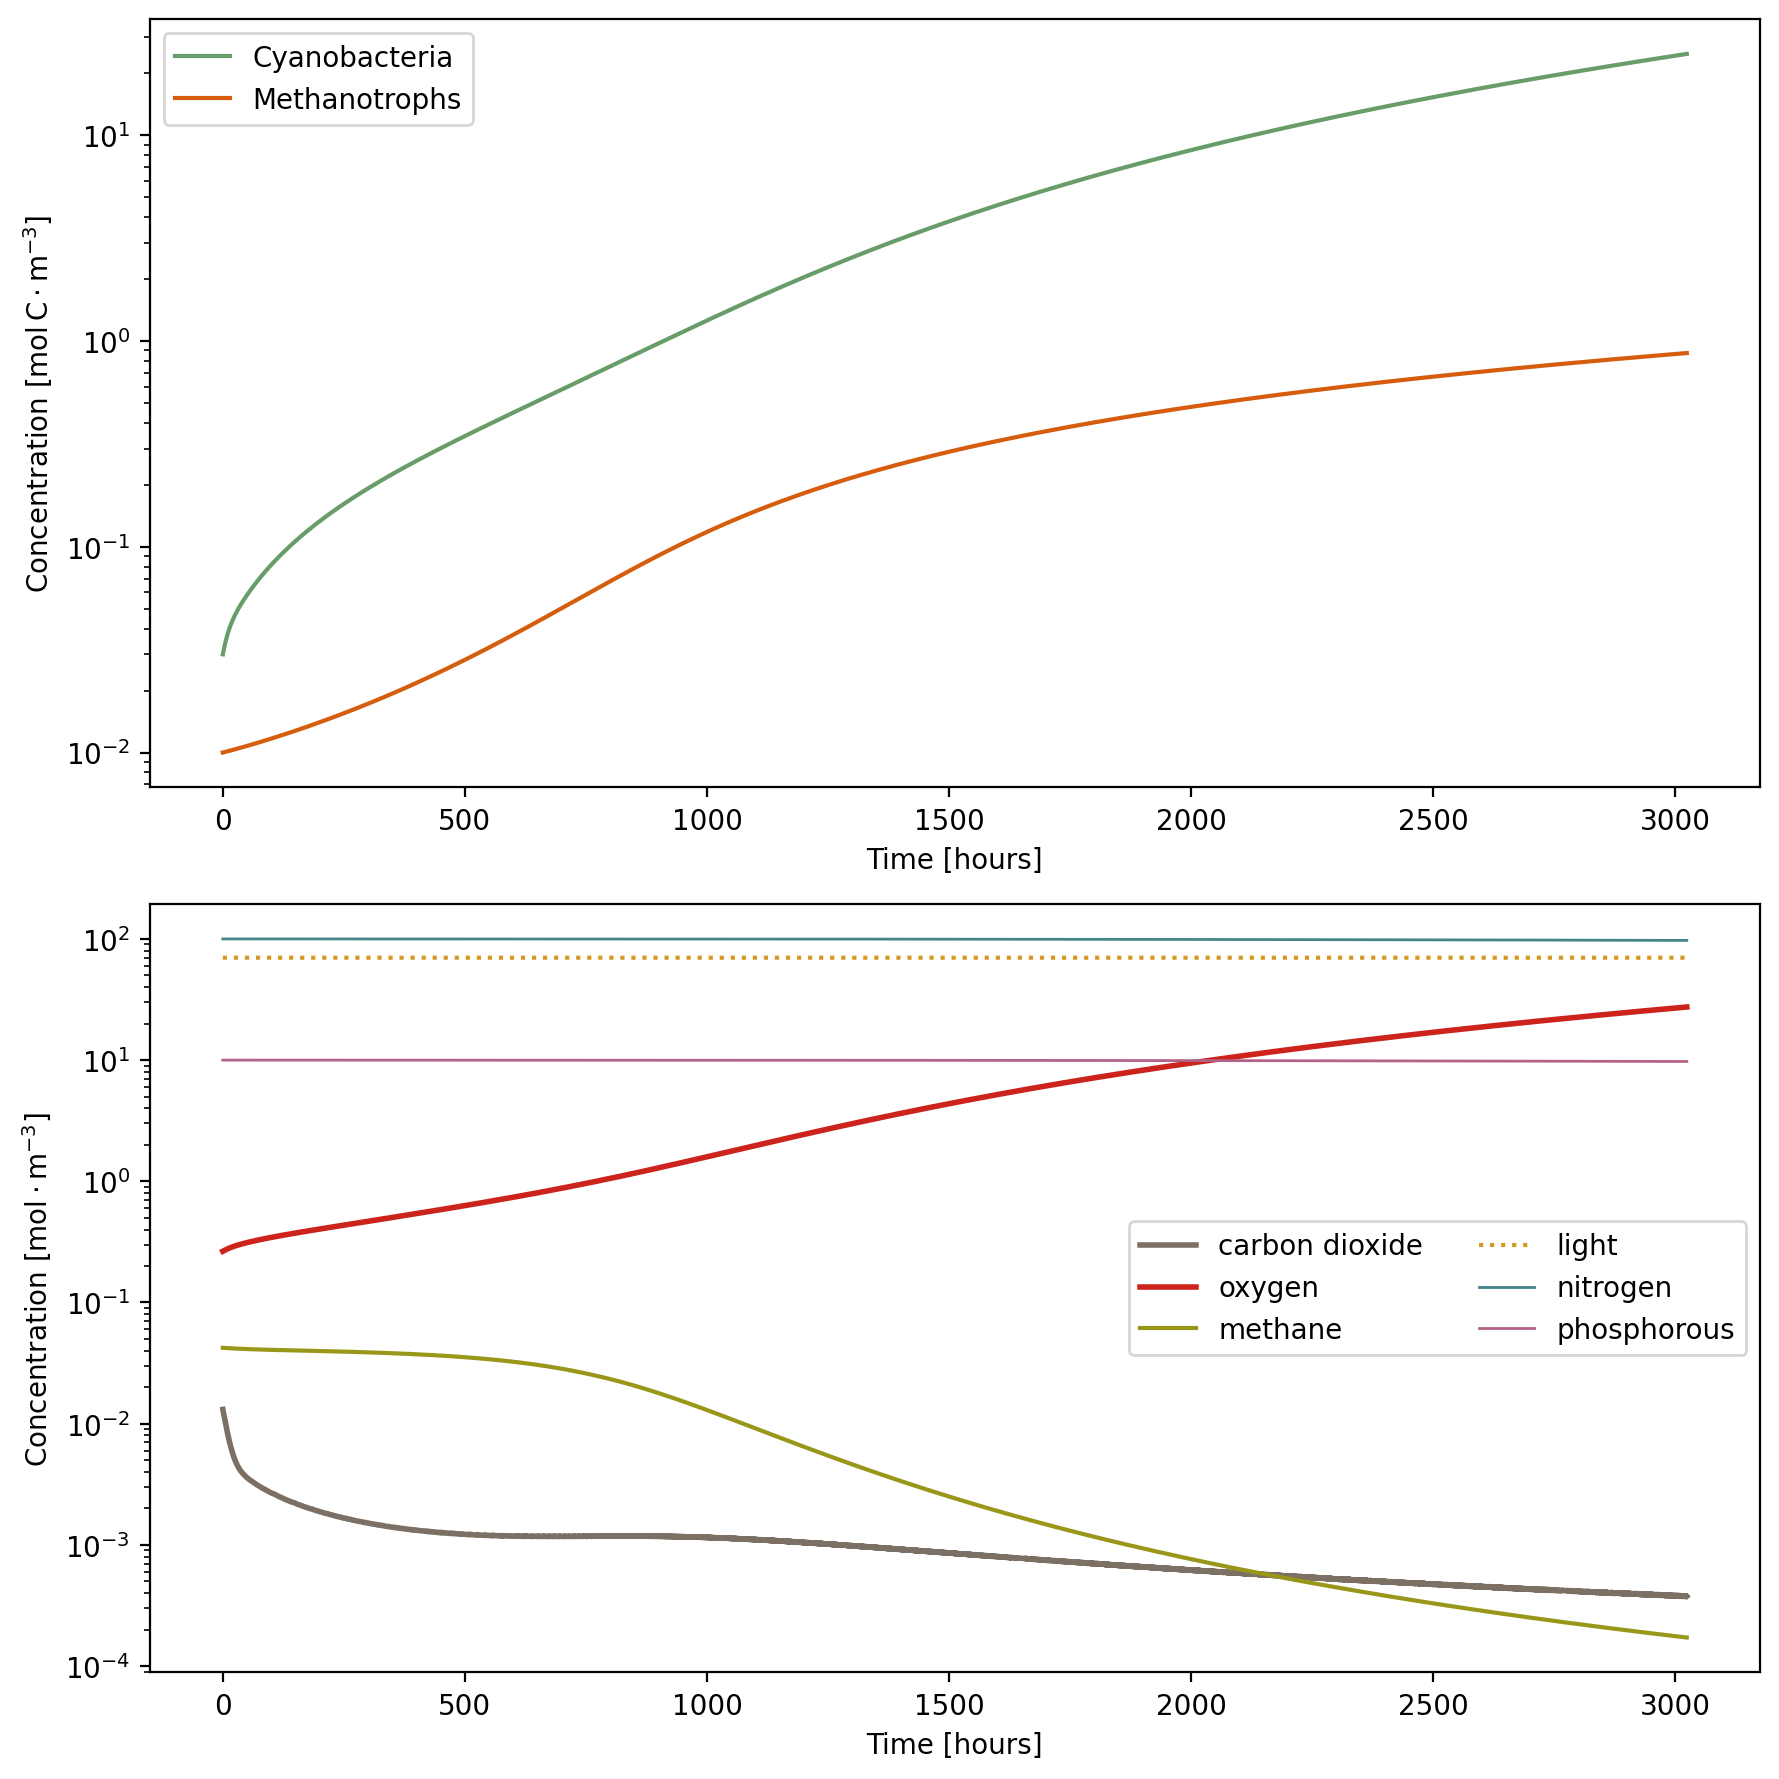

In [10]:
# Plot the results:
# left: Concentrations of Cyanobacteria (cyan: #689d6a) and Methanotrophs (orange: #d65d0e) over time.
# middle: Concentrations of oxygen (red: #cc241d), carbon dioxide (gray: #7c6f64) and methane (purple: #b16286) over time.
# right: Trajectory of the system in the concentration space of Cyanobacteria (x) and Methanotrophs (y).

fig = plt.figure( figsize=(9,9), dpi=200 )
axs = fig.add_gridspec( 2, 1, height_ratios=[1,1] )

ax = fig.add_subplot( axs[0,0] )
ax.plot(sol.t / 3600, sol.y[0], label='Cyanobacteria', color='#689d6a')
ax.plot(sol.t / 3600, sol.y[1], label='Methanotrophs', color='#d65d0e')
ax.set_xlabel('Time [hours]')
ax.set_ylabel('Concentration [$\mathrm{mol}\,\mathrm{C}\cdot\mathrm{m}^{-3}$]')
ax.set_yscale("log")
ax.legend()


ax = fig.add_subplot( axs[1,0] )
ax.plot(sol.t / 3600, sol.y[2], label='carbon dioxide', color='#7c6f64', lw=2)
ax.plot(sol.t / 3600, sol.y[3], label='oxygen', color='#cc241d', lw=2)
ax.plot(sol.t / 3600, sol.y[4], label='methane', color='#98971a', lw=1.5)
ax.plot(sol.t / 3600, sol.y[5], label='light', color='#d79921', lw=1.5, ls=':')
ax.plot(sol.t / 3600, sol.y[6], label='nitrogen', color='#458588', lw=1)
ax.plot(sol.t / 3600, sol.y[7], label='phosphorous', color='#b16286', lw=1)
ax.set_xlabel('Time [hours]')
ax.set_ylabel('Concentration [$\mathrm{mol}\cdot\mathrm{m}^{-3}$]')
ax.set_yscale("log")
ax.legend(ncols=2)

plt.tight_layout()
plt.show()

fig.patch.set_alpha(0.0)
fig.savefig( "Cell Culture Dynamics v1.png", dpi=300, bbox_inches='tight', pad_inches=0.0 )